In [1]:
#!unzip 64x64_SIGNS.zip

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class Net(nn.Module):
    def __init__(self, num_channels):
        super(Net, self).__init__()

        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.conv2 = nn.Conv2d(
            self.num_channels, self.num_channels * 2, 3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(self.num_channels * 2)
        self.conv3 = nn.Conv2d(
            self.num_channels * 2, self.num_channels * 4, 3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(self.num_channels * 4)

        self.fc1 = nn.Linear(self.num_channels * 4 * 8 * 8, self.num_channels * 4)
        self.bn4 = nn.BatchNorm1d(self.num_channels * 4)
        self.fc2 = nn.Linear(self.num_channels * 4, 6)

    def forward(self, x):
        # 3 x 64 x 64
        x = self.conv1(x)
        x = self.bn1(x)
        # num_channels x 64 x 64
        x = F.max_pool2d(x, 2)
        # num_channels x 32 x 32
        x = F.relu(x)
        x = F.dropout2d(x, 0.2)

        x = self.conv2(x)
        x = self.bn2(x)
        # num_channels * 2 x 32 x 32
        x = F.max_pool2d(x, 2)
        # num_channels * 2 x 16 x 16
        x = F.relu(x)
        x = F.dropout2d(x, 0.2)

        x = self.conv3(x)
        x = self.bn3(x)
        # num_channels * 4 x 16 x 16
        x = F.max_pool2d(x, 2)
        # num_channels * 4 x 4 x 4
        x = F.relu(x)
        x = F.dropout2d(x, 0.2)

        x = x.view(-1, self.num_channels * 4 * 8 * 8)

        # self.num_channels * 4 * 8 * 8
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2)

        # self.num_channels * 4
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        # 6
        return x

In [6]:
class SIGNSDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        path = os.path.join(base_dir, f"{split}_signs")
        files = os.listdir(path)
        self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")]
        self.targets = [int(f[0]) for f in files]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        if self.transform:
            image = self.transform(image)
        return image, self.targets[idx]

In [7]:
transform = transforms.Compose(
    [
        transforms.RandomRotation([0, 180]),
        transforms.RandomPerspective(),
        transforms.ColorJitter(
            brightness=(0.5, 1.5), contrast=(1), saturation=(0.5, 1.5), hue=(-0.1, 0.1)
        ),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [8]:
splits = ["train", "val", "test"]
data_loaders = {
    split: DataLoader(
        SIGNSDataset("64x64_SIGNS", split=split, transform=transform), batch_size=64
    )
    for split in splits
}

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  #

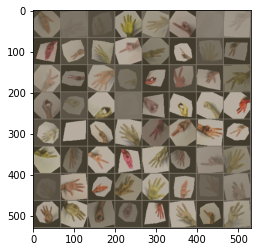

tensor([5, 3, 3, 5, 5, 1, 4, 2, 4, 2, 4, 1, 4, 1, 5, 2, 2, 2, 5, 1, 0, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 1, 5, 2, 2, 4, 2, 1, 4, 2, 4, 4, 4, 1, 5,
        5, 5, 5, 3, 5, 5, 3, 3, 5, 5, 0, 0, 4, 4, 1, 4])


In [10]:
for inputs, targets in data_loaders["train"]:
    out = make_grid(inputs)
    imshow(out)
    print(targets)
    break

In [11]:
class RunningMetric:
    def __init__(self):
        self.S = 0
        self.N = 0

    def update(self, val, size):
        self.S += val
        self.N += size

    def __call__(self):
        return self.S / float(self.N)

In [12]:
def train_and_evaluate(
    model, optimizer, loss_fn, data_loaders, device, num_epoch=10, lr=0.01
):
    for g in optimizer.param_groups:
        g["lr"] = lr

    for epoch in range(num_epoch):
        print(f"Epoch {epoch}/{num_epoch}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = RunningMetric()
            running_acc = RunningMetric()

            for inputs, targets in data_loaders[phase]:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = loss_fn(outputs, targets)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.size()[0]
                running_loss.update(loss.item() * batch_size, batch_size)
                running_acc.update(torch.sum(preds == targets).float(), batch_size)

            print(
                "{} Loss: {:.4f} Acc: {:.4f}".format(
                    phase, running_loss(), running_acc()
                )
            )

    return model, running_loss(), running_acc()

In [13]:
net = Net(64).to(device)
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [20]:
models = train_and_evaluate(net, optimizer, loss_fn, data_loaders, device, 300, lr=1e-2)

Epoch 0/300
----------
train Loss: 0.8692 Acc: 0.6771
val Loss: 0.9197 Acc: 0.6435
Epoch 1/300
----------
train Loss: 0.9010 Acc: 0.6493
val Loss: 1.0137 Acc: 0.6019
Epoch 2/300
----------
train Loss: 0.9076 Acc: 0.6319
val Loss: 1.0398 Acc: 0.6574
Epoch 3/300
----------
train Loss: 0.9388 Acc: 0.6354
val Loss: 0.8727 Acc: 0.6481
Epoch 4/300
----------
train Loss: 0.9570 Acc: 0.6285
val Loss: 0.9661 Acc: 0.6065
Epoch 5/300
----------
train Loss: 0.9329 Acc: 0.6227
val Loss: 0.9515 Acc: 0.5926
Epoch 6/300
----------
train Loss: 0.9196 Acc: 0.6343
val Loss: 0.8693 Acc: 0.6343
Epoch 7/300
----------
train Loss: 0.8972 Acc: 0.6308
val Loss: 0.8223 Acc: 0.7037
Epoch 8/300
----------
train Loss: 0.9202 Acc: 0.6308
val Loss: 0.9265 Acc: 0.6111
Epoch 9/300
----------
train Loss: 0.8821 Acc: 0.6343
val Loss: 0.9600 Acc: 0.6250
Epoch 10/300
----------
train Loss: 0.8866 Acc: 0.6609
val Loss: 0.9389 Acc: 0.6389
Epoch 11/300
----------
train Loss: 0.9095 Acc: 0.6296
val Loss: 0.8987 Acc: 0.6019
Ep

In [21]:
# Test
net.eval()

running_loss = RunningMetric()
running_acc = RunningMetric()

for inputs, targets in data_loaders["test"]:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        loss = loss_fn(outputs, targets)

    batch_size = inputs.size()[0]
    running_loss.update(loss.item() * batch_size, batch_size)
    running_acc.update(torch.sum(preds == targets).float(), batch_size)

print("Test Loss: {:.4f} Acc: {:.4f}".format(running_loss(), running_acc()))

Test Loss: 0.4767 Acc: 0.8333


In [22]:
torch.save(net.state_dict(), "model")

In [23]:
net.eval()
with torch.set_grad_enabled(False):
    inf_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    image = Image.open("fs.png")
    image = inf_transform(image)
    forward = net.forward(image.reshape(1, 3, 64, 64))
    print(forward)
    print(torch.argmax(forward))

tensor([[-2.9006e+01, -3.1585e+01, -3.4745e+01, -2.3512e+01, -1.0360e+01,
         -3.1709e-05]])
tensor(5)
